In [ ]:
!pip install wntr matplotlib numpy magnets viswaternet openpyxl

# Overview

In this Jupyter Notebook, our goal is to explore different model representation and visualization options provided by WNTR as well as Python packages that build on WNTR. This is our agenda:

1. Use WNTR for visualization
2. Explore network visualization options provided by VisWaterNet
3. Demonstrate WNTR skeletonization
4. Demonstrate model reduction using the package MAGNets

For our analyses, we will use BWFLNet, a model of a real water distribution network. The Bristol Water Field Lab (BWFL) network is part of the water distribution network of the city of Bristol, UK, and it serves approximately 8,000 customer connections. BWFLnet is an operational network in Bristol, UK, operated by Bristol Water. The data provided is a the product of a long term research partnership between Bristol Water and Infrasense Labs at Imperial College London. The BWFLnet model and data set can be found [here](https://data.mendeley.com/datasets/srt4vr5k38/1).

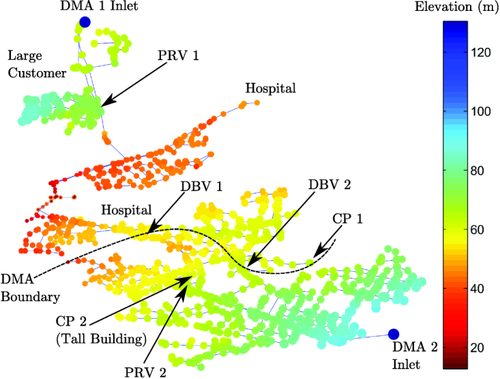

Let us begin by importing in the INP file of the model. Note that this model has been slightly modified from the original model in the following ways:
1. some demand patterns are exactly the same as others so we have merged them
2. all TCVs in the model have been replaced with equivalent pipes

Our first step is to import the Python packages we need into this file:

In [ ]:
%matplotlib inline

#import packages
import wntr
import matplotlib.pyplot as plt
import numpy as np
import time

We now define the INP file and initialize a water network model object using WNTR.

In [ ]:
# import bwfl
inp = 'Networks/BWFLnet_modified.inp'

# initialize water network model object
wn = wntr.network.WaterNetworkModel(inp)

We will now run a hydraulic simulation with WNTR (using the EPANET 2.2 engine), store the simulation time, and examine the number of compenents in the network.

In [ ]:
# run wntr simulation and record simulation time
sim = wntr.sim.EpanetSimulator(wn)

t1 = time.time()
results = sim.run_sim()
t2 = time.time()

simtime = t2-t1
print('The simulation run time was ', simtime, 's')

# describe the number of components in the system
wn.describe()

Remember that this real network has several important junctions that we must keep track of. Here, we define (1) a list of junction names representing locations of pressure sensors, (2) a list of junctions that are assigned different demand patterns as well as (3) their neighboring nodes.

In [ ]:
# list of junctions where pressure sensors are installed
pressure_sensors_list = ['node_1925', 'node_1938', 'node_1961', 'node_1971', 
                         'node_1983', 'node_0354', 'node_2012', 'node_2046', 
                         'node_2113', 'node_0785', 'node_2188', 'node_2197', 
                         'node_2210', 'node_2243', 'node_2265', 'node_2285', 
                         'node_1194', 'node_1202', 'node_2354', 'node_2428', 
                         'node_2440', 'node_2441', 'node_1738', 'node_2485', 
                         'node_1781', 'node_1876', 'node_2535']

# list of junctions with different demand patterns ...
diff_demand_pattern_list = ['node_0640', 'node_0870', 'node_0973', 'node_1122', 'node_1311', 
                            'node_1363', 'node_1388', 'node_1685', 'node_1813', 'node_2125', 
                            'node_2130', 'node_2167', 'node_2184', 'node_2220', 'node_2307']

# ... and their neighbors
diff_demand_neighbor_list = ['node_0595', 'node_0647', 'node_0648', 'node_2168', 'node_2152', 
                             'node_0907', 'node_0952', 'node_2199', 'node_2206', 'node_1121',
                             'node_2260', 'node_1315', 'node_1340', 'node_2350', 'node_1385',
                             'node_1386', 'node_1402', 'node_2439', 'node_2446', 'node_2456',
                             'node_1807', 'node_0718', 'node_2140', 'node_2112', 'node_0755',
                             'node_0890', 'node_0868', 'node_0913', 'node_0984', 'node_1037',
                             'node_1223', 'node_1262']

# list of all critical nodes
critical_nodes = pressure_sensors_list + diff_demand_pattern_list + diff_demand_neighbor_list

# Network Visualization Using WNTR

Now that we have established the model, let us look at its network layout. We start by using WNTR's ```plot_network``` function to visualize the model and its critcal nodes.

In [ ]:
# water network layout 
wntr.graphics.plot_network(wn, node_attribute = critical_nodes, node_size=10, title='Original Model')

We can also use WNTR to visualize attributes across the network, such as mean pressure at all nodes.

In [ ]:
# create plot showing mean pressure at all nodes in the network
mean_pressure = results.node['pressure'].mean()
ax = wntr.graphics.plot_network(wn, node_attribute=mean_pressure, node_colorbar_label='Mean Pressure [m]')

WNTR's ```plot_network``` function provides a solid starting point for network visualization, but we would like to take their visualization capabilities onoe step further. We would like to be able to generate plots with customizable legends in place of colorbars, have the ability to label and highlight specific nodes, visualize user-generated and categorical data, and easily create animations showing time-varying properties. 

# Network Visualization Using VisWaterNet

Here, we introduce another new tool: VisWaterNet, a Python package for easy generation and customization of water distribution network visualizations. VisWaterNet allows for the plotting of continuous, discrete, and categorical data, as well as custom data provided by the user (either through a list imported into the script or an Excel file). Below is a description of the different VisWaterNet functions: 

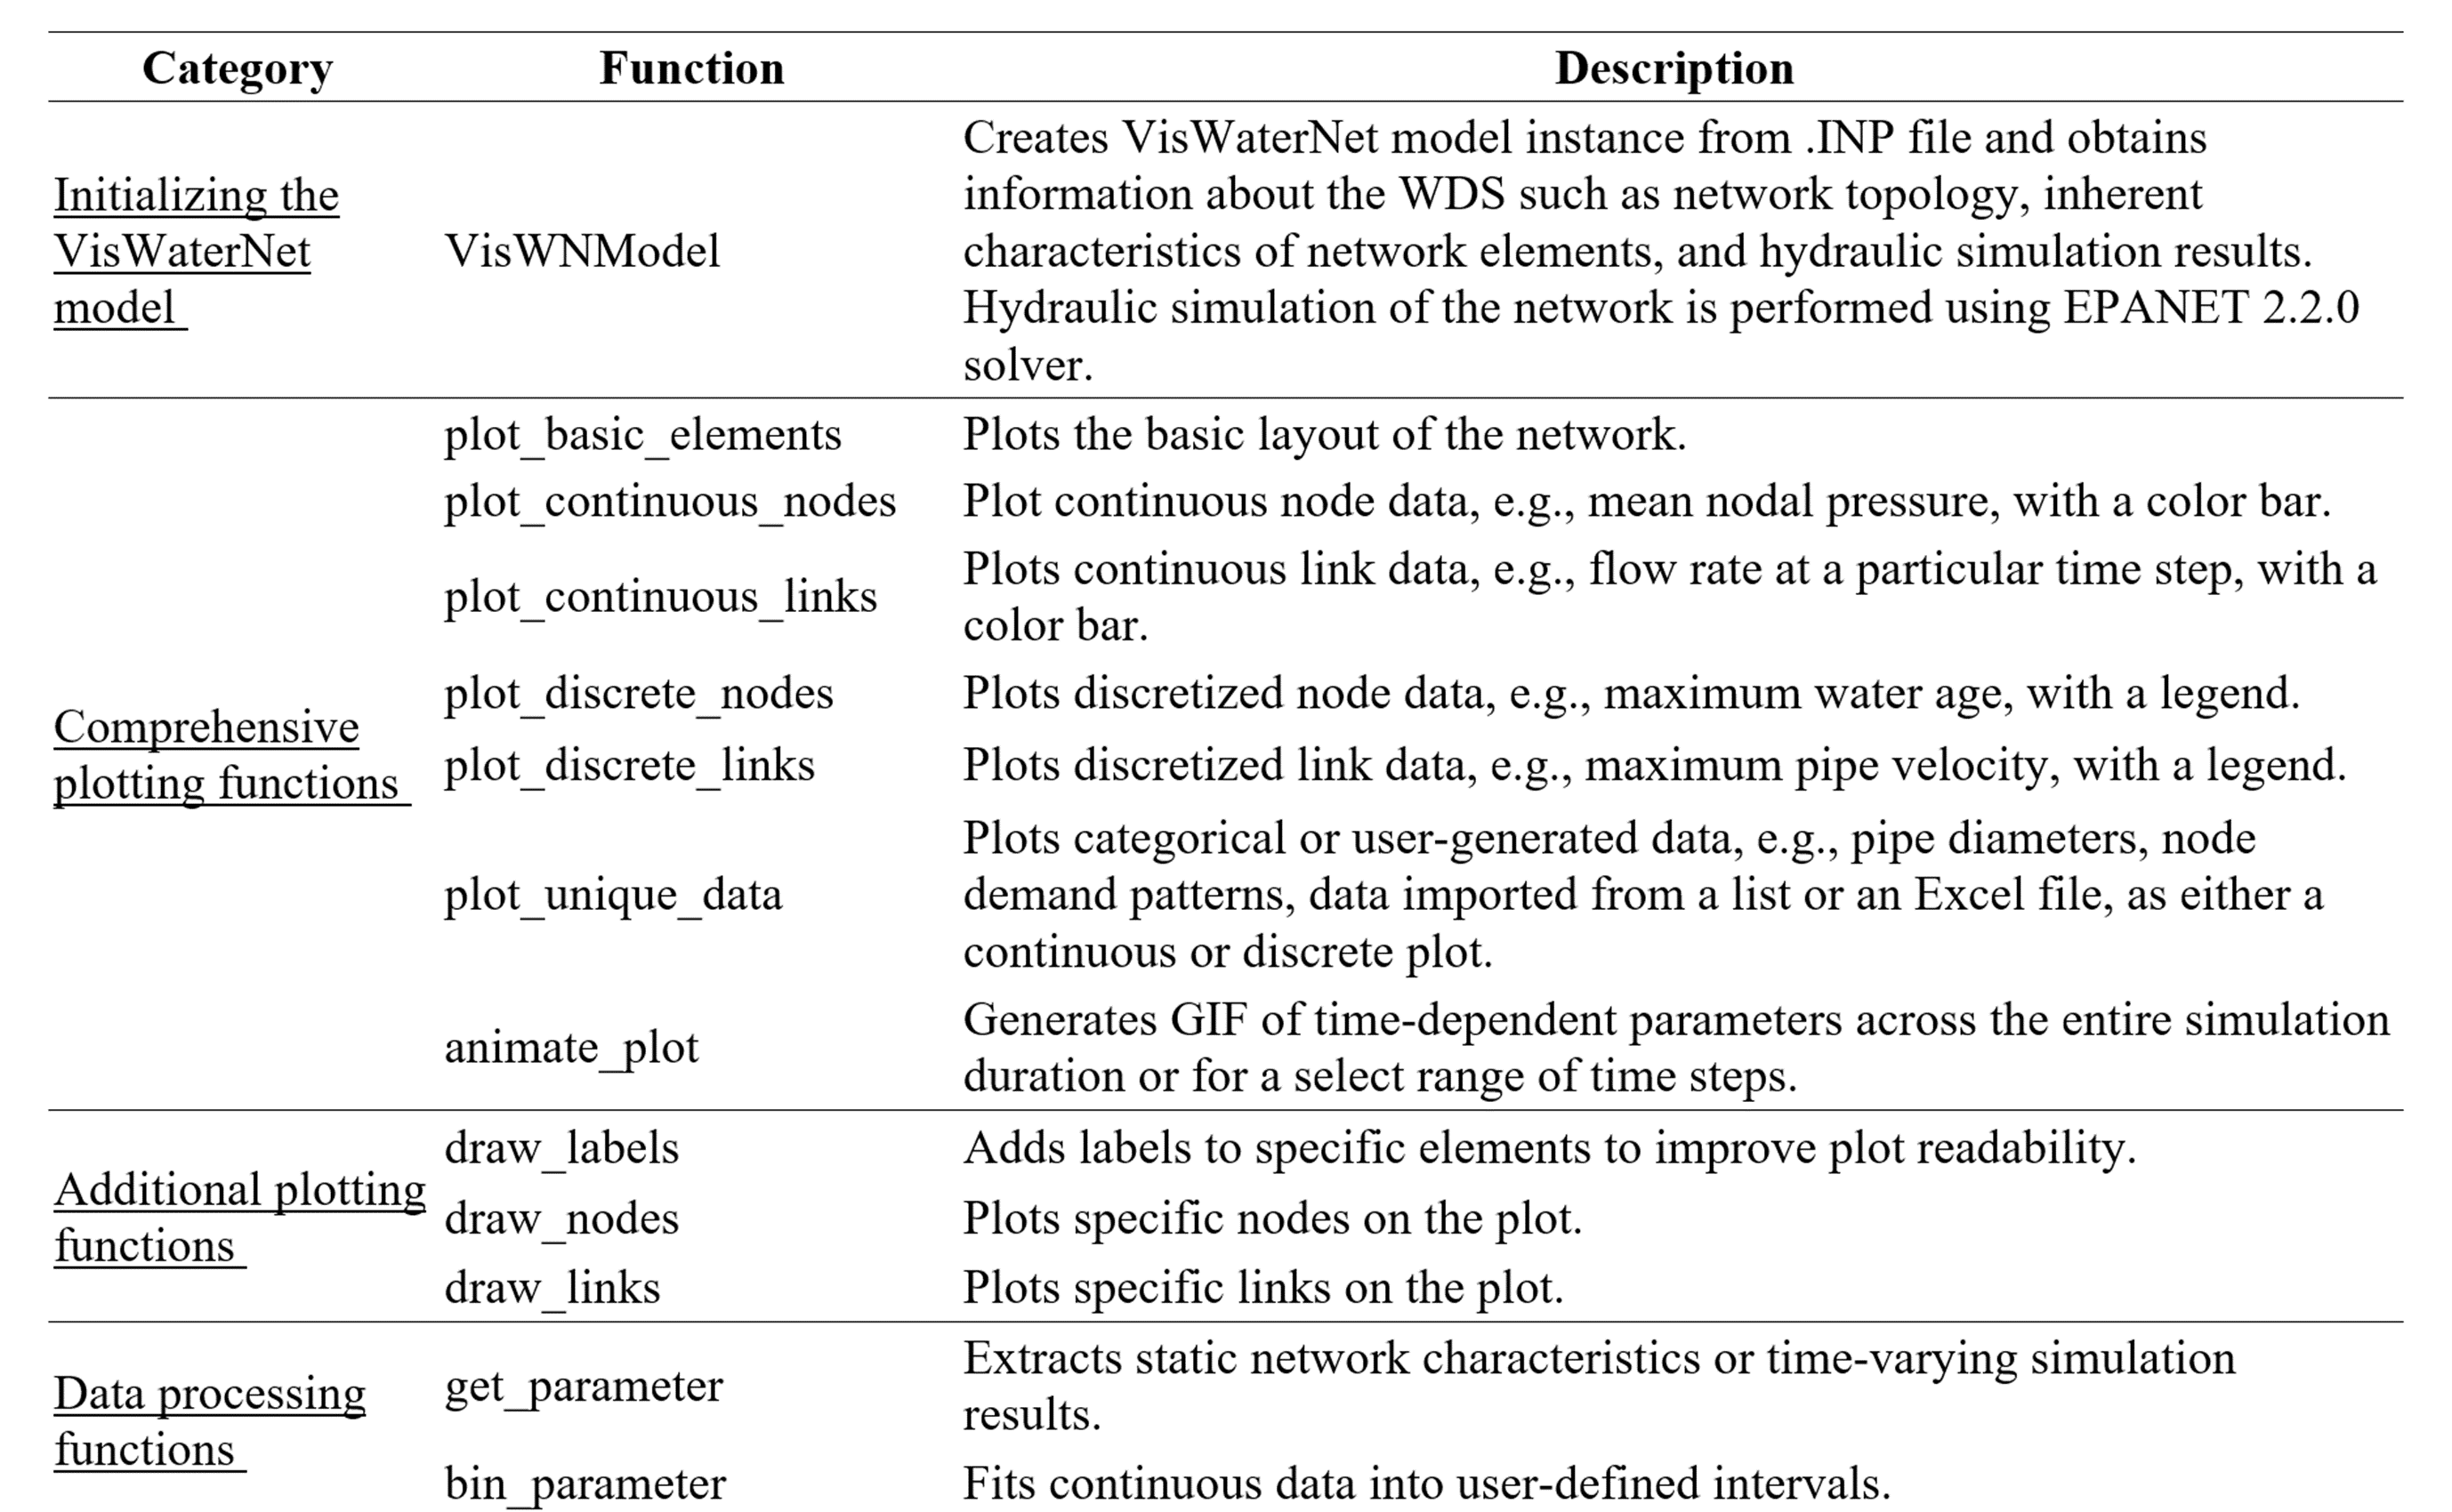

We will use VisWaterNet ```plot_basic_elements``` function to plot original the model network layout, and use the ```draw_nodes``` function to highlight the location of our critical nodes.

In [ ]:
# import viswaternet into the script
import viswaternet as vis

# initialize a viswaternet model object from the .INP file
model=vis.VisWNModel(inp)

# initialize matplotlib figure
fig, ax = plt.subplots(figsize=(8,8))
ax.set_frame_on(False)

# plot water network layout 
model.plot_basic_elements(ax=ax, # matplotlib axis
                          base_node_size=1, reservoir_size = 200, valve_size = 150, # change size of elements
                          base_legend_label_font_size = 10,  # customize base legend font size
                          reservoir_border_width = 1, reservoir_color='tab:cyan', # customize reservoir markers
                          valve_color='tab:red') # customize valve markers

# highlight pressure sensors
model.draw_nodes(ax=ax, node_list=pressure_sensors_list, node_color='lime', node_shape ='*', node_border_width = 1)  

# highlight nodes with different demand patterns
model.draw_nodes(ax=ax, node_list=diff_demand_pattern_list, node_color='tab:orange', node_shape ='^', node_border_width = 1)

# label PRVs
prv_start_node_list = []
prv_list = []
for valve_name, valve in wn.valves():
    if valve.valve_type == 'PRV':
        prv_start_node_list.append(valve.start_node_name)
        prv_list.append(valve_name)
model.draw_label(ax=ax, draw_nodes=prv_start_node_list, labels=prv_list, 
                 x_coords=[-1000]*len(prv_list), y_coords=[-3000]*len(prv_list), 
                 label_font_size = 8, label_face_color = 'salmon')
        

# build a legend for the highlighted nodes
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='lime', marker='*', markersize=10, lw=0),
                 Line2D([0], [0], color='tab:orange', marker='^', markersize=10, lw=0)]
leg_labels = ['Pressure sensor', 'Different demand pattern node']
legend = ax.legend(custom_lines, leg_labels, fontsize=10,  loc=3, frameon=False)
ax.add_artist(legend)

# save figure
plt.tight_layout()
plt.savefig('network layout.png', dpi = 400)

Now, we will look at more options for network visualization using VisWaterNet.

First, we will create a discrete plot of pressure at the nodes based on the WNTR simulation results. On the left will be the automatically produced plot, and we will demonstrate the easy customization capabilities of VisWaterNet in the plot on the right.

In [ ]:
# initialize matplotlib subplots
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].set_frame_on(False)
model.plot_discrete_nodes(ax=ax[0], parameter = 'pressure', value = 'mean', 
                          discrete_legend_loc = 'upper right', discrete_legend_label_font_size = 9, 
                          discrete_legend_title_font_size = 11, 
                          base_legend_loc = 'lower left', base_legend_label_font_size=10)

ax[1].set_frame_on(False)
model.plot_discrete_nodes(ax=ax[1], parameter='pressure', value = 'mean', 
                          color_list = ['red', 'green', 'orange'], # assign colors to intervals
                          intervals=[0,30,80],  # specify legend intervals
                          discrete_legend_loc = 'upper right', discrete_legend_label_color = 'interval_color', # customize legend
                          discrete_legend_label_font_size = 9, discrete_legend_title_font_size = 11,  # customize legend
                          legend_decimal_places = 0, draw_base_legend = False, # customize legends
                          valve_size=80, reservoir_size=80, node_size=50) # customize element markers

Using VisWaterNet's function ```plot_unique_data```, we can also create categorical plots representing user-supplied data. In the plot shown below, the material of each pipe is drawn from the provided Excel sheet and represented graphically.

In [ ]:
# plot pipe materials with data from excel sheet
model.plot_unique_data(parameter = 'excel_data', parameter_type = 'link',
                       data_file = 'Excel/bwflnet_materials.xlsx', # path to excel file 
                       excel_columns = [0,1], # these values represent excel file column indices of (0) list of nodes/links to plot and (1) their corresponding data points
                       data_type = 'unique', # data type: could be continuous (with colorbar) or discrete/unique (with legend)
                       cmap='tab20', draw_base_legend = False, 
                       discrete_legend_loc = 'upper right', discrete_legend_label_font_size=12, 
                       link_width=2)

We can also use ```plot_unique_data``` to (i) plot data from lists, and (ii) plot data for subsets of elements. For example, here we generate synthetic pressure estimates for 100 random junctions and plot the difference between these estimates and the WNTR pressure simulation results.

In [ ]:
# generate random data
import random

random.seed(1)
estimate_list = []
diff_list = []

element_list = random.sample(wn.junction_name_list,100)

for junc_name in element_list:
    new_estimate = results.node['pressure'].loc[0, junc_name]*random.uniform(0.8, 1.2)
    estimate_list.append(new_estimate)
    diff_list.append(results.node['pressure'].loc[0, junc_name] - new_estimate)


In [ ]:
model.plot_unique_data(parameter = "custom_data", node_size = 200,
                   parameter_type = "node", data_type = "continuous", 
                   custom_data_values = [element_list, diff_list],
                   node_border_width = 1, node_border_color = "k",
                   color_bar_title = "Error (%)", cmap = "bwr")

VisWaterNet can also create animated plots using the ```animate_plot``` function. In this example, a trace at the nodes from the lower reservoir (node_2547) is shown.

In [ ]:
fig, ax = plt.subplots(figsize=(8,8));
ax.set_frame_on(False);
model.animate_plot(function = model.plot_continuous_nodes, 
                   ax=ax, parameter = 'quality', 
                   cmap = 'Blues', valve_color = 'yellow', 
                   node_size = (0,200),
                   node_border_width = 0.5, node_border_color = 'lightgray',
                   first_timestep=0, last_timestep=None, time_unit = 'hr', 
                   color_bar_title = 'Trace from lower reservoir [%]',
                   fps = 1, save_name = 'traceplot', save_format='gif', dpi = 400);

In [ ]:
# display gif
from IPython.display import Image
Image(open('traceplot.gif','rb').read())

# Model Reduction Using WNTR

We see that the BWFLNet model has over 2,500 nodes and links. Hydraulic models of complex water networks, such as this one, can be expensive to run in terms of computational effort and time. Therefore, we can turn to **reduced** or **skeletonized** models to speed up model running times and facilitate real-time decision making. **Model reduction** or **skeletonization** refers to the method of reducing the size of a network model to an equivalent model with fewer components and similar accuracy. 

Here, we will first demonstrate WNTR's skeletonization function which allows users to specify if they would like to remove or merge dead-end pipes, pipes connected in series, and pipes connected in parallel. A required function argument is the ```pipe_diameter_threshold```: all pipes with diameters <= this diameter are candidates for removal.

Let us call on the WNTR ```skeletonize``` function to remove pipes with a diameter less than 3 ft from the model and check how many components remain.

In [ ]:
#skeletonize model using WNTR
wn2 = wntr.morph.skeletonize(wn, pipe_diameter_threshold = 0.254*3)

wn2.describe()

This model is about half the size of the original model! Let's see how much faster the reduced model runs compared to the original model.

In [ ]:
#run wntr simulation
sim2 = wntr.sim.EpanetSimulator(wn2)
t1 = time.time()
results2 = sim2.run_sim()
t2 = time.time()

simtime2 = t2 - t1
print('The simulation run time for the reduced model was ', simtime2, 's, which is ', str(round(simtime2/simtime, 2)),
      ' times faster than the original model.')

We will now generate some plots to confirm that the pressures at junctions remaining in the reduced model are, indeed, equivalent to the pressures at the same junctions in the original model. Let us pick two nodes at locations of pressure sensors and plot time series plots of WNTR simulation results for both the original and reduced model junction pressure heads.

In [ ]:
#comparing the head at two different nodes in the regular and reduced networks: 
node1, node2 = 'node_0469', 'node_1194'

#obtain head data for each network
head, head2 = results.node['head'], results2.node['head']

#obtain data for critical node 1
head_at_node1, reduced_head_at_node1 = head.loc[:,node1], head2.loc[:,node1]

#obtain data for critical node 2
head_at_node2, reduced_head_at_node2 = head.loc[:,node2], head2.loc[:,node2]

#plot reduced and original model pressure head time series at two critical nodes 
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(head_at_node1.index/3600, head_at_node1, color='k', lw = 2)
ax[0].plot(reduced_head_at_node1.index/3600, reduced_head_at_node1, 
           linestyle = '--', color='orange', lw = 2)
ax[0].set_title(node1)
ax[0].set_xlabel('Time [hr]')
ax[0].set_ylabel('Pressure head [m]')
ax[0].legend(['Original model', 'Reduced model'])

ax[1].plot(head_at_node2.index/3600, head_at_node2, color='k', lw = 2)
ax[1].plot(reduced_head_at_node2.index/3600, reduced_head_at_node2, 
           linestyle = '--', color = 'orange', lw = 2)
ax[1].set_title(node2)
ax[1].set_xlabel('Time [hr]')
plt.show()

Let us now check if all critical junctions have been retained in the reduced model.

In [ ]:
#check if all pressure sensor nodes are present in the reduced model
print('Number of critical nodes: ', len(critical_nodes))

critical_nodes_in_rm = []
for junction_name in critical_nodes:
    if junction_name in wn2.junction_name_list:
        critical_nodes_in_rm.append(junction_name)
        
print('Number of critical nodes in reduced model: ', len(critical_nodes_in_rm))

It looks like not all of the critical nodes were left in the reduced model! Let us confirm by plotting both network plots, and we will highlight the location of the two nodes that we observed pressure head for:

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# write reduced model to .INP file
wntr.network.io.write_inpfile(wn2,'Networks/BWFLnetmodified_skeletonized.inp')
model2=vis.VisWNModel('Networks/BWFLnetmodified_skeletonized.inp')

# plot original model
ax[0].set_frame_on(False)
model.plot_basic_elements(ax=ax[0], base_node_size = 3, reservoir_size = 50, reservoir_border_width = 1, 
                          valve_size = 50, base_legend_label_font_size = 10)
model.draw_nodes(ax=ax[0], node_list=pressure_sensors_list + diff_demand_pattern_list, node_color='red', node_shape ='*')

# plot reduced model
ax[1].set_frame_on(False)
model2.plot_basic_elements(ax=ax[1], base_node_size = 3, reservoir_size = 50, reservoir_border_width = 1, 
                           valve_size = 50, base_legend_label_font_size = 10)
model2.draw_nodes(ax=ax[1], node_list=critical_nodes_in_rm, node_color='red', node_shape ='*')

# highlight and label the two nodes that we examined pressures for
model.draw_nodes(ax=ax[0], node_list=[node1, node2], node_color='yellow', node_size=100, node_border_width = 1)
model.draw_label(ax=ax[0], draw_nodes=[node1, node2], labels=[node1, node2], 
                 x_coords=[2500]*2, y_coords=[2500]*2, # this 
                label_font_size=6)
model2.draw_nodes(ax=ax[1], node_list=[node1, node2], node_color='yellow', node_size=100, node_border_width = 1)
model2.draw_label(ax=ax[1], draw_nodes=[node1, node2], labels=[node1, node2], 
                 x_coords=[2500]*2, y_coords=[2500]*2,
                label_font_size=6)
plt.show()

It appears that not all of the critical nodes remain in the reduced model.

We will now look into another Python-based tool that builds on WNTR to offer advanced model reduction capabilities.

# Model Reduction Using MAGNets

Let us start with the Python package MAGNets (Model AGgregation and reduction of water distribution Networks). MAGNets is a Python package designed to perform the reduction and aggregation of water distribution network models. The software is capable of reducing a network around an optional operating point and allows the user to customize which junctions they would like retained in the reduced model as well as the level of reduction. MAGNets' reduction approach is based on the variable elimination method proposed by [Ulanicki et al (1996)](https://www.researchgate.net/publication/273796660_Simplification_of_Water_Distribution_Network_Models).

We first import the MAGNets Python package into the file.

In [ ]:
import magnets as mg

The user can then call on the following function to reduce a hydraulic model of a water distribution network. 

```wn2 = mg.reduction.reduce_model(inp_file, op_pt, nodes_to_keep, max_nodal_degree, save_filename)```

The parameters of the `reduce_model` function are described as follows:

`inp_file`: the EPANET-compatible .INP file of the water distribution network model.

`op_pt`: (optional, default = 0) the operating point, or the reporting time step of the hydraulic simulation at which the non-linear headloss equations are linearized.

`nodes_to_keep`: (optional, default = []) a list of nodes the user wishes to retain in the reduced model.

`max_nodal_degree`: (optional, default = None) the maximum nodal degree of nodes being removed from the model. The nodal degree of a node is equal to the number of pipes incident to the node.

`save_filename`: (optional, default = None) a user-specified name assigned to the newly generated .INP file of the reduced model.

`wn2` contains the water network model object of the reduced model. A .INP file of the reduced model is also written into the directory that contains the .INP file of the original network.

Let us see what MAGNets is capable of. We first specify a nodal degree of 1, an operating point of 0, and specify that we would like to retain all critical nodes in the reduced model.

## Reduce model with max_nodal_degree = 1

In [ ]:
#define inp_file
inp = 'Networks/BWFLnet_modified.inp'

#specify operating point, nodes to keep
op_pt = 0

#max nodal degree = 1
max_nodal_degree1 = 1

#call model reduction
t1 = time.time()
wn2 = mg.reduction.reduce_model(inp_file = inp,
                                op_pt = op_pt,
                                nodes_to_keep = critical_nodes,
                                max_nodal_degree = max_nodal_degree1,
                                save_filename = 'Networks/BWFLnet_modified_level1')  #mg1 is a wntr network model
t2 = time.time()

Let us examine the network plots and number of components of the original and reduced models.

In [ ]:
#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], base_node_size=3, reservoir_size=100, reservoir_color='blue', reservoir_border_width = 2, valve_size =100, valve_color ='red')
# highlight pressure sensors
model.draw_nodes(ax=ax[0], node_list=pressure_sensors_list, node_color='lime', node_shape ='*', node_border_width = 1)  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[0], node_list=diff_demand_pattern_list, node_color='tab:orange', node_shape ='^', node_border_width = 1)

#plot reduced network
model1=vis.VisWNModel('Networks/BWFLnet_modified_level1.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], base_node_size=3, reservoir_size=100, reservoir_color='blue', reservoir_border_width = 2, valve_size =100, valve_color ='red')
# highlight pressure sensors
model.draw_nodes(ax=ax[1], node_list=pressure_sensors_list, node_color='lime', node_shape ='*', node_border_width = 1)  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[1], node_list=diff_demand_pattern_list, node_color='tab:orange', node_shape ='^', node_border_width = 1)
plt.show()

In [ ]:
# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn2.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn2.num_pipes, "\033[0;0m")

We have generated a much smaller model while retaining all critical nodes, and the reduction process only took a few seconds.

Next, we will reduce the same model defining a different  ```max_nodal_degree ``` each time to see how this impacts the reduction.

## Reduce nodes with max_nodal_degree = 2

In [ ]:
#max nodal degree 2
max_nodal_degree2 = 2

#call model reduction
t1 = time.time()
wn3 = mg.reduction.reduce_model(inp, op_pt, critical_nodes, max_nodal_degree2, 'Networks/BWFLnet_modified_level2')
t2 = time.time()

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], base_node_size=3, reservoir_size=100, reservoir_color='blue', reservoir_border_width = 2, valve_size =100, valve_color ='red')
# highlight pressure sensors
model.draw_nodes(ax=ax[0], node_list=pressure_sensors_list, node_color='lime', node_shape ='*', node_border_width = 1)  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[0], node_list=diff_demand_pattern_list, node_color='tab:orange', node_shape ='^', node_border_width = 1)

#plot reduced network
model1=vis.VisWNModel('Networks/BWFLnet_modified_level2.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], base_node_size=3, reservoir_size=100, reservoir_color='blue', reservoir_border_width = 2, valve_size =100, valve_color ='red')
# highlight pressure sensors
model.draw_nodes(ax=ax[1], node_list=pressure_sensors_list, node_color='lime', node_shape ='*', node_border_width = 1)  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[1], node_list=diff_demand_pattern_list, node_color='tab:orange', node_shape ='^', node_border_width = 1)
plt.show()

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn3.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn3.num_pipes, "\033[0;0m")

## Reduce nodes with max_nodal_degree = 3

In [ ]:
#max nodal degree 3
max_nodal_degree3 = 3

#call model reduction
t1 = time.time()
wn4 = mg.reduction.reduce_model(inp, op_pt, critical_nodes, max_nodal_degree3, 'Networks/BWFLnet_modified_level3')
t2 = time.time()

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], base_node_size=3, reservoir_size=100, reservoir_color='blue', reservoir_border_width = 2, valve_size =100, valve_color ='red')
# highlight pressure sensors
model.draw_nodes(ax=ax[0], node_list=pressure_sensors_list, node_color='lime', node_shape ='*', node_border_width = 1)  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[0], node_list=diff_demand_pattern_list, node_color='tab:orange', node_shape ='^', node_border_width = 1)

#plot reduced network
model1=vis.VisWNModel('Networks/BWFLnet_modified_level3.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], base_node_size=3, reservoir_size=100, reservoir_color='blue', reservoir_border_width = 2, valve_size =100, valve_color ='red')
# highlight pressure sensors
model.draw_nodes(ax=ax[1], node_list=pressure_sensors_list, node_color='lime', node_shape ='*', node_border_width = 1)  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[1], node_list=diff_demand_pattern_list, node_color='tab:orange', node_shape ='^', node_border_width = 1)
plt.show()

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn4.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn4.num_pipes, "\033[0;0m")

## Reduce nodes with max_nodal_degree = None (all nodes that are not in the critical_nodes list or connected to reservoirs, tanks, pumps, or valves will be removed)

In [ ]:
#max nodal degree = none
max_nodal_degree = None

#call model reduction
t1 = time.time()
wn5 = mg.reduction.reduce_model(inp, op_pt, critical_nodes, max_nodal_degree,'Networks/BWFLnet_modified_full')
t2 = time.time()

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], base_node_size=3, reservoir_size=100, reservoir_color='blue', reservoir_border_width = 2, valve_size =100, valve_color ='red')
# highlight pressure sensors
model.draw_nodes(ax=ax[0], node_list=pressure_sensors_list, node_color='lime', node_shape ='*', node_border_width = 1)  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[0], node_list=diff_demand_pattern_list, node_color='tab:orange', node_shape ='^', node_border_width = 1)

#plot reduced network
model1=vis.VisWNModel('Networks/BWFLnet_modified_full.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], base_node_size=3, reservoir_size=100, reservoir_color='blue', reservoir_border_width = 2, valve_size =100, valve_color ='red')
# highlight pressure sensors
model.draw_nodes(ax=ax[1], node_list=pressure_sensors_list, node_color='lime', node_shape ='*', node_border_width = 1)  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[1], node_list=diff_demand_pattern_list, node_color='tab:orange', node_shape ='^', node_border_width = 1)
plt.show()

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn5.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn5.num_pipes, "\033[0;0m")

As can be seen from the graphs above, the reduced networks vary greatly and the reduction time increases as the maximum nodal degree increases. 

We will now run a time series comparison of the pressure heads at two critical to ensure that the pressure at the remaining junctions is similar in each of these models.

In [ ]:
#run simulations and note time
sim = wntr.sim.EpanetSimulator(wn)
t1 = time.time()
results = sim.run_sim()
t2 = time.time()
sim_time_orig = t2-t1

sim2 = wntr.sim.EpanetSimulator(wn2)
t1 = time.time()
results2 = sim2.run_sim()
t2 = time.time()
sim_time_1 = t2-t1

sim3 = wntr.sim.EpanetSimulator(wn3)
t1 = time.time()
results3 = sim3.run_sim()
t2 = time.time()
sim_time_2 = t2-t1

sim4 = wntr.sim.EpanetSimulator(wn4)
t1 = time.time()
results4 = sim4.run_sim()
t2 = time.time()
sim_time_3 = t2-t1

sim5 = wntr.sim.EpanetSimulator(wn5)
t1 = time.time()
results5 = sim5.run_sim()
t2 = time.time()
sim_time_none = t2-t1


In [ ]:
#obtain head data for each network
head=results.node['head']
head2 = results2.node['head']
head3=results3.node['head']
head4=results4.node['head']
head5=results5.node['head']

#obtain data for critical node 1
head_at_node1 = head.loc[:,node1]
reduced_head_at_node1_2 = head2.loc[:,node1]
reduced_head_at_node1_3 = head3.loc[:,node1]
reduced_head_at_node1_4 = head4.loc[:,node1]
reduced_head_at_node1_5 = head5.loc[:,node1]

#obtain data for critical node 2
head_at_node2 = head.loc[:,node2]
reduced_head_at_node2_2 = head2.loc[:,node2]
reduced_head_at_node2_3 = head3.loc[:,node2]
reduced_head_at_node2_4 = head4.loc[:,node2]
reduced_head_at_node2_5 = head5.loc[:,node2]

#plot reduced and original model pressure head time series at two critical nodes 
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(head_at_node1.index/3600, head_at_node1, lw = 2, color = 'k')
ax[0].plot(reduced_head_at_node1_2.index/3600, reduced_head_at_node1_2, linestyle = '--', lw = 2)
ax[0].plot(reduced_head_at_node1_3.index/3600, reduced_head_at_node1_3, linestyle = '--', lw = 2)
ax[0].plot(reduced_head_at_node1_4.index/3600, reduced_head_at_node1_4, linestyle = '-.', lw = 2)
ax[0].plot(reduced_head_at_node1_5.index/3600, reduced_head_at_node1_5, linestyle = ':', lw = 2)
ax[0].set_title(node1)
ax[0].set_xlabel('Time [hr]')
ax[0].set_ylabel('Pressure head [m]')


ax[1].plot(head_at_node2.index/3600, head_at_node2, lw = 2, color = 'k')
ax[1].plot(reduced_head_at_node2_2.index/3600, reduced_head_at_node2_2, linestyle = '--', lw = 2)
ax[1].plot(reduced_head_at_node2_3.index/3600, reduced_head_at_node2_3, linestyle = '--', lw = 2)
ax[1].plot(reduced_head_at_node2_4.index/3600, reduced_head_at_node2_4, linestyle = '-.', lw = 2)
ax[1].plot(reduced_head_at_node2_5.index/3600, reduced_head_at_node2_5, linestyle = ':', lw = 2)
ax[1].set_title(node2)
ax[1].set_xlabel('Time [hr]')
ax[1].legend(['Original model', 'Reduced model: max_nodal_degree = 1','Reduced model: max_nodal_degree = 2', 'Reduced model: max_nodal_degree = 3','Reduced model: max_nodal_degree = None'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Let us examine the simulation running times (in seconds) and speed up (decrease in running time compared to the original model).

In [ ]:
import pandas as pd
data = np.array([[sim_time_orig, sim_time_orig/sim_time_orig], 
                 [sim_time_1, sim_time_orig/sim_time_1], 
                 [sim_time_2, sim_time_orig/sim_time_2], 
                 [sim_time_3, sim_time_orig/sim_time_3], 
                 [sim_time_none, sim_time_orig/sim_time_none]]).T
pd.DataFrame(data, 
             columns=['Original model', 'Reduced model: degree 1','Reduced model: degree 2', 'Reduced model:degree 3','Reduced model: degree None'],
            index=['Running time [s]', 'Speedup']).round(2)

We can see that the reduced models run much faster than the original model. All of these results demonstrate that reduced models can be used in a range of studies and applications to speed up simulation running times while preserving pressures throughout the system. Users are encouraged to carefully choose which nodes should remain in the model, the degree of reduction they require depending on their problem requirements.

We hope you have found this tutorial useful! For more information on these packages, you can find our Github repositories and published papers below:

[VisWaterNet Github repository](https://github.com/tylertrimble/viswaternet)

[VisWaterNet paper in the Journal of Open Source Software](https://joss.theoj.org/papers/10.21105/joss.05139)

[MAGNets Github repository](https://github.com/meghnathomas/MAGNets)

[MAGNets paper in the Journal of Water Resources Planning and Management](https://ascelibrary.org/doi/full/10.1061/JWRMD5.WRENG-5486)